# Pytorch ConvNet Distinguishing Men and Women

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')

##### Loading all file names

In [2]:
files = glob('combined/*.jpg')
files = np.random.permutation(files)

In [3]:
files[:5]

array(['combined\\81_1_0_20170109150922380.jpg.chip.jpg',
       'combined\\26_1_1_20170113011638655.jpg.chip.jpg',
       'combined\\34_0_1_20170117014054215.jpg.chip.jpg',
       'combined\\62_1_0_20170110122436007.jpg.chip.jpg',
       'combined\\23_1_3_20170109132112364.jpg.chip.jpg'], dtype='<U47')

##### Keeping all correctly formatted labels

In [4]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Keeping only men/women (not both)

In [5]:
faces = [i for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [6]:
y = [i[-34] for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [7]:
sex = ['men', 'women']

In [8]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### Getting shape info

In [9]:
# nrow, ncol, nchan = 200, 200, 3
nrow, ncol, nchan = 60, 60, 3

#### This is the shape width/height

In [10]:
dim = 60

#### Cropping function

In [11]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [12]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces)
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')
y = y[:num_to_load]

Done. 12 seconds


##### Turning the pictures into arrays

In [13]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [14]:
x.shape

(20638, 60, 60)

In [15]:
assert x.ndim == 3

In [16]:
yy, xx = y.nbytes, x.nbytes

In [17]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 297,187,200 bytes and the size of Y is 82,552 bytes.


In [18]:
files, faces = None, None

##### Displaying the pictures

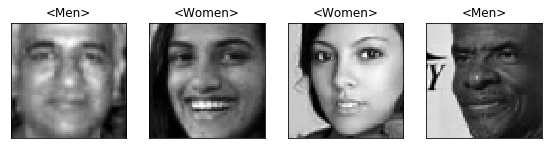

In [19]:
np.random.seed(42)
rand = np.random.randint(x.shape[0])
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(10)
    ax = plt.imshow(x[rand], cmap='gray')
    plt.title('<{}>'.format(sex[int(y[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

##### Cross-validation

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
x, y = None, None

In [21]:
trainsize, testsize = x_train.shape[0], x_test.shape[0]
print(f'The size of the training set is {trainsize:,} and the '\
     f'size of the test set is {testsize:,}.')

The size of the training set is 16,510 and the size of the test set is 4,128.


##### Scaling, casting the arrays

In [22]:
print('Scaling...', end='')
image_size = x_train.shape[1] * x_train.shape[1] 
x_train = x_train.reshape(-1, 1, dim, dim).astype('float32') / 255 
x_test = x_test.reshape(-1, 1, dim, dim).astype('float32') / 255
print('\rDone.     ')

Done.     


In [23]:
x_train.shape

(16510, 1, 60, 60)

##### Sending the arrays to Cuda

In [24]:
if torch.cuda.is_available():
    x_train = torch.from_numpy(x_train) 
    x_test = torch.from_numpy(x_test) 
    y_train = torch.from_numpy(y_train) 
    y_test = torch.from_numpy(y_test)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Building the ConvNet

In [25]:
# RuntimeError: size mismatch, m1: [16 x 1600], m2: [3200 x 1024]

In [26]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        
        self.fc1 = nn.Linear(5*5*64, 1024) 
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 1)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [27]:
net = ConvNet()

In [28]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [40]:
loss_function = nn.BCELoss()

##### Instantiating the data

In [41]:
class FaceTrain():
    
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_train = x_train
        self.y_train = y_train
        
    def __getitem__(self, index):
        return x_train[index], y_train[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

In [42]:
class FaceTest():
    
    def __init__(self):
        self.len = x_test.shape[0]
        self.x_test = x_test
        self.y_test = y_test
        
    def __getitem__(self, index):
        return x_test[index], y_test[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Making instances of the data

In [43]:
train = FaceTrain()
test = FaceTest()

##### Making data iterator

In [44]:
train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=True)

##### Training the model

In [45]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         inputs, labels = Variable(inputs), Variable(labels)
#         ypred = net(inputs)
#         loss = loss_function(ypred, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     output = (ypred>0.5).float()
#     correct = (output == labels).float().sum()
#     print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1, 
#                                 num_epochs, loss.item(), correct/output.shape[0]))

In [47]:
epochs = 1
steps = 0
running_loss = 0
print_every = 100
train_losses, test_losses = [], []
device = 'cpu'
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = net.forward(inputs)
        loss = loss_function(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs)
                    batch_loss = loss_function(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape).type(torch.LongTensor)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            net.train()

Epoch 1/10.. Train loss: 0.622.. Test loss: 0.572.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.477.. Test loss: 0.512.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.414.. Test loss: 0.389.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.363.. Test loss: 0.402.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.346.. Test loss: 0.358.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.362.. Test loss: 0.312.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.324.. Test loss: 0.353.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.327.. Test loss: 0.309.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.312.. Test loss: 0.409.. Test accuracy: 0.535
Epoch 1/10.. Train loss: 0.313.. Test loss: 0.307.. Test accuracy: 0.535
Epoch 2/10.. Train loss: 0.300.. Test loss: 0.283.. Test accuracy: 0.535
Epoch 2/10.. Train loss: 0.283.. Test loss: 0.283.. Test accuracy: 0.535
Epoch 2/10.. Train loss: 0.291.. Test loss: 0.322.. Test accuracy: 0.535
Epoch 2/10.. Train loss: 0.254.. Test loss: 0.293..

This doesn't work. Back to the drawing board. We'll make a proof of concept using Keras, which is faster to write. Then we'll implement a working model with Pytorch again.